In [1]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from bgan.datasets import SynthDataset
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import UninformativePrior, FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [5]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.SVHN(root='/scratch/pi49/datasets/svhn/', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

Using downloaded and verified file: /scratch/pi49/datasets/svhn/train_32x32.mat


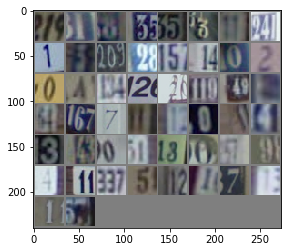

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [8]:
trainset[0][0].size()

torch.Size([3, 32, 32])

In [11]:
def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
def gen_weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = self.conv4(x)
        x = x.squeeze()

        return x


In [12]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())


torch.Size([10, 3, 32, 32])
torch.Size([10])


In [13]:
from bgan.bgan_wasserstein import WBGAN

In [14]:
batch_size = 50
z_dim = 100

In [15]:
# prior = UninformativePrior()
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()
# gen.apply(weight_init)
gen.apply(gen_weight_init)
disc.apply(weight_init)
bgan = WBGAN(gen, disc, prior, alpha=.9, eta=5e-5, disc_lr = 5e-5, gen_observed=20000, MAP=False, cuda=True)
samples = []

Moving generator and discriminator to GPU
TODO: Weight Clipping constants?
TODO: RMSProp?


In [16]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))

torch.Size([100, 512, 4, 4]) 18.103
torch.Size([512]) 0.0
torch.Size([512]) 13.205
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 28.954
torch.Size([256]) 0.0
torch.Size([256]) 9.48895
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 14.4661
torch.Size([128]) 0.0
torch.Size([128]) 6.65235
torch.Size([128]) 0.0
torch.Size([128, 3, 4, 4]) 1.55507
torch.Size([3]) 0.0


## Training

In [17]:
num_samples = 10

In [62]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(10):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.d_step(batch)
        if not (i%5):
            bgan.g_step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv.cuda())
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).cpu().data.numpy())
samples = np.vstack(samples)

	 -25798.3 12661.9
0
	 -19489.5 5263.73
1
	 -28613.1 13606.7
2
	 -15600.1 -1230.57
3
	 -32671.7 13965.9
4
	 -38622.6 18826.2
5
	 -42080.9 19107.4
6
	 -45523.1 21358.9
7
	 -40726.3 20863.0
8
	 -59442.3 29432.6
9


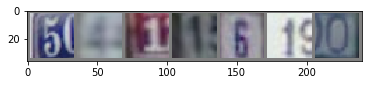

In [63]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [64]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [65]:
# samples = bgan.sample(100).cpu().data.numpy()

In [66]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [67]:
samples_arr.shape

(250, 3, 32, 32)

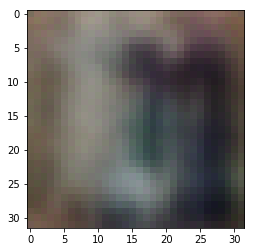

In [68]:
plt.imshow((samples_arr[-1]/2 + 0.5).transpose(1, 2, 0))

In [69]:
samples_arr[-1].shape#.transpose(0, 1, 3, 2).shape

(3, 32, 32)

In [70]:
np.max(batch.numpy())

0.90588236

In [71]:
samples_arr.shape

(250, 3, 32, 32)

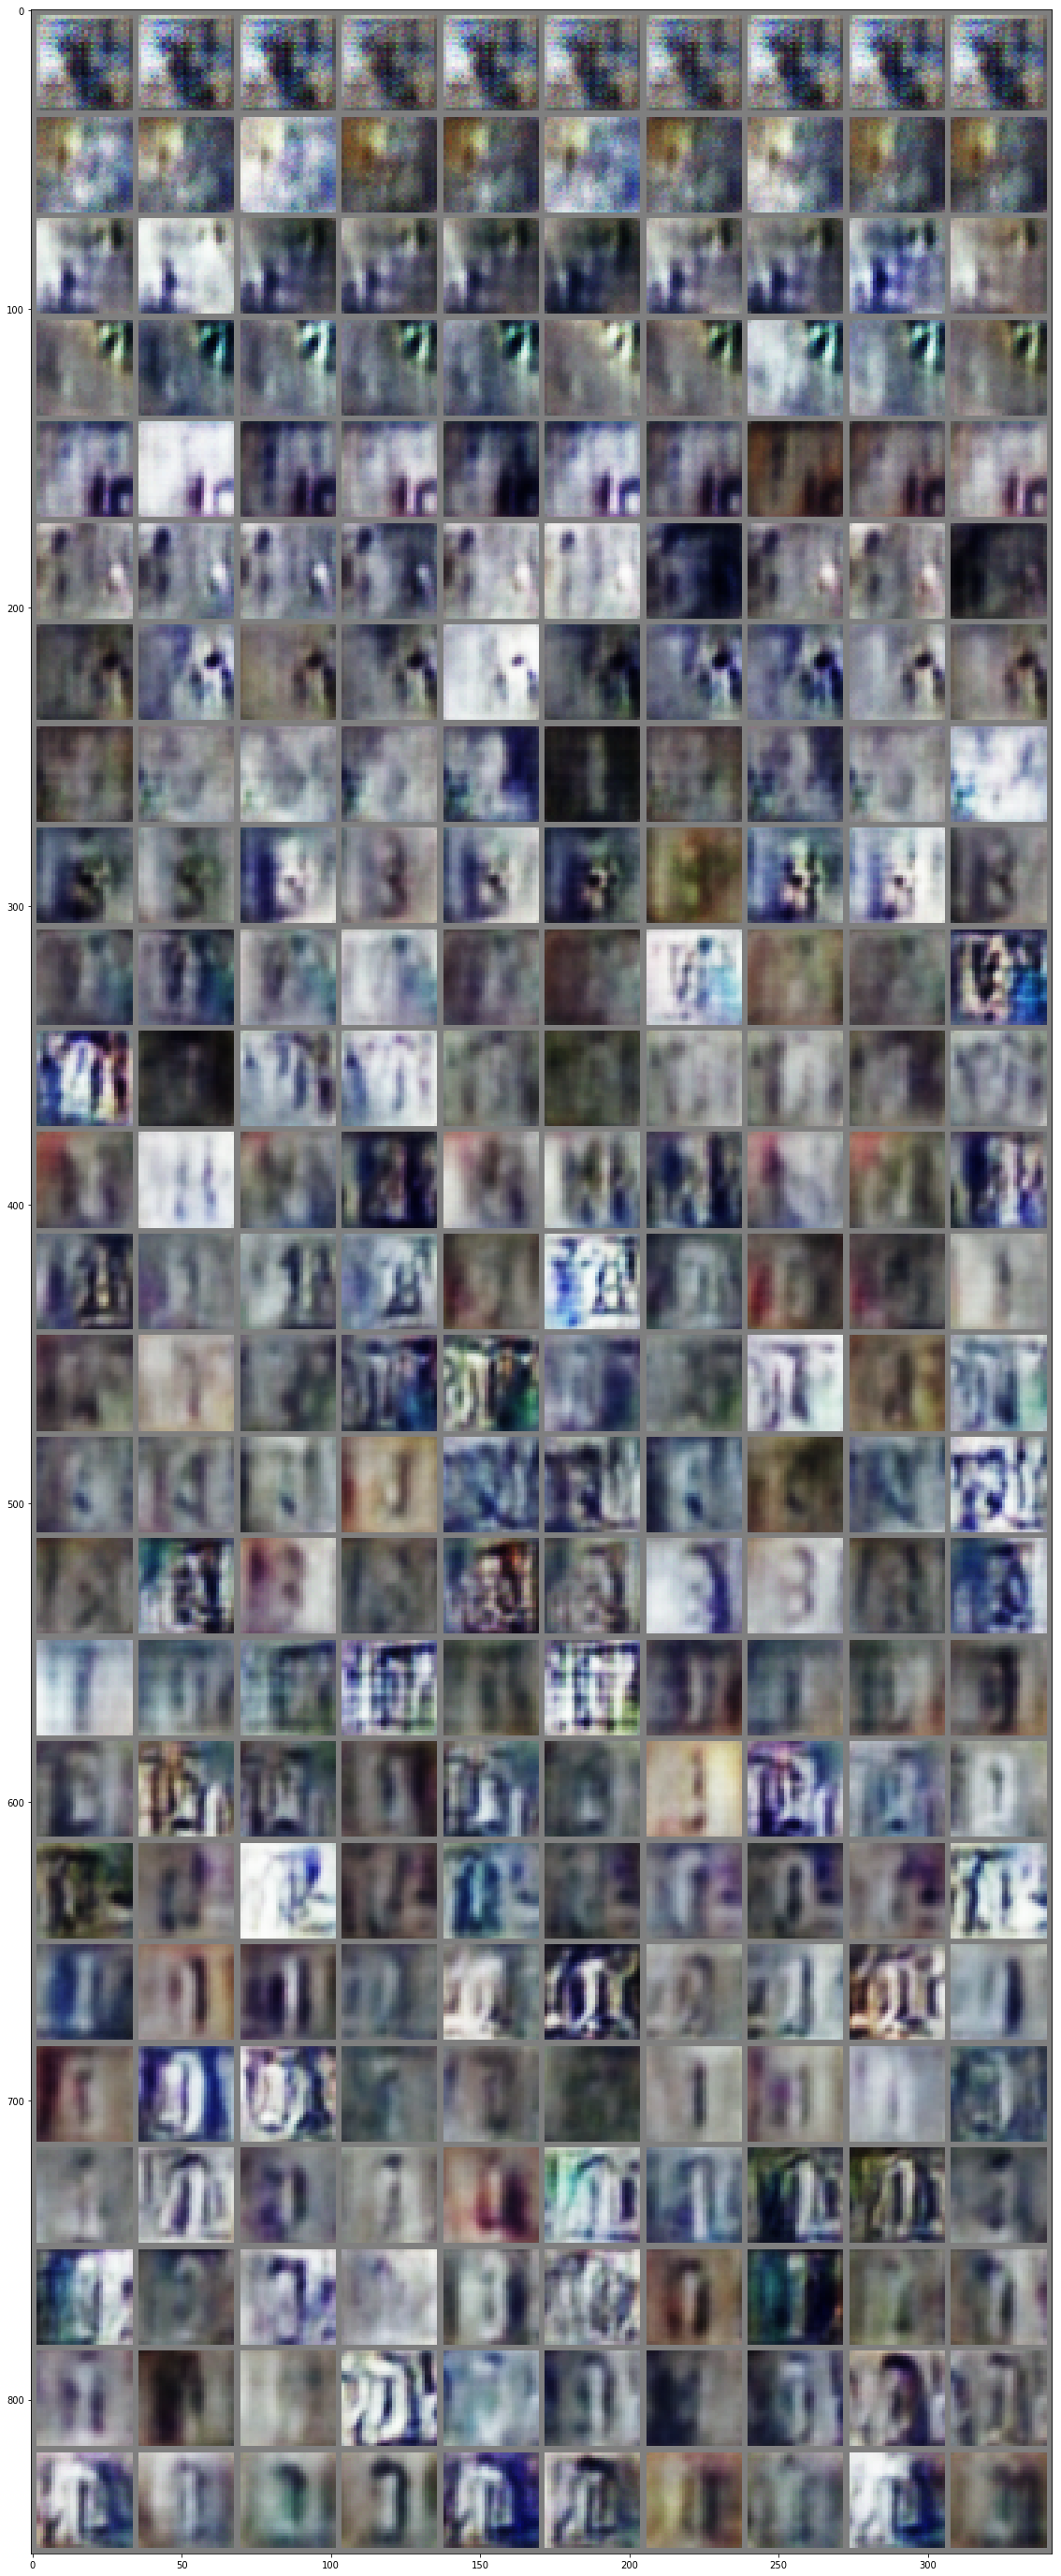

In [72]:
plt.figure(figsize=(20, 50))
show_epochs = [20, 30]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
# imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[-1000:]), nrow=10))


In [295]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())

In [296]:
sample_probs

Variable containing:
-25784.9180
-27183.7188
-33335.4258
-29572.7383
-27180.7598
-25571.9141
-26551.5195
-27172.4570
-27497.0254
-25923.6152
-23267.3750
-25067.2266
-23645.5195
-21503.6680
-26248.9902
-20159.5098
-27569.8984
-26983.8125
-24824.2891
-25774.6582
-24792.4277
-22394.5039
-27315.1523
-25447.2148
-26852.3691
-24594.2656
-29343.9609
-27258.7324
-28836.9629
-28337.1191
-17920.0645
-25666.1680
-27639.8457
-19407.2168
-20521.2559
-24141.1152
-22194.6914
-26242.2695
-20551.9258
-28257.9375
-29950.5078
-27920.1719
-24239.5176
-35220.6406
-27055.6055
-24398.0879
-32537.7520
-28001.4785
-20649.8145
-29444.0391
-26921.0664
-28967.7480
-24995.1191
-21600.3398
-26154.7715
-20326.2051
-21532.8457
-24375.4473
-24019.3867
-23799.8672
-21905.5332
-22393.7480
-23543.7539
-26248.2871
-19989.3770
-23744.7949
-26325.0508
-34484.0117
-21337.4609
-23841.1133
-21850.2031
-25686.5352
-26190.2227
-26309.8945
-27305.3750
-15479.9277
-25738.0020
-28513.0371
-24458.4805
-23477.7109
-29836.7207
-22553.

In [233]:
disc(Variable(batch).cuda())

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 50 (GPU 0)]